<a href="https://colab.research.google.com/github/vhenaoi/ProyectoSSVEP/blob/main/Procesamiento_2021_welch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Procesamiento de registros correspondientes al 2021**

### **Elementos necesarios para la importación**
---

Montaje del drive personal



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importación de librerias necesarias para el manejo de la señal

In [ ]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import pandas as pd 
import os
from os import listdir
from os.path import isfile, join

Se descomprime un paquete de filtros alojado en el drive personal

In [ ]:
!unzip '/content/drive/MyDrive/Visión Sábados/Codigos/Librerias/librerias.zip'

Archive:  /content/drive/MyDrive/Visión Sábados/Codigos/Librerias/librerias.zip
  inflating: linearFIR.py            
   creating: __MACOSX/
  inflating: __MACOSX/._linearFIR.py  
   creating: chronux/
   creating: chronux/__pycache__/
  inflating: chronux/__pycache__/qeeg_psd_chronux.cpython-37.pyc  
   creating: __MACOSX/chronux/
   creating: __MACOSX/chronux/__pycache__/
  inflating: __MACOSX/chronux/__pycache__/._qeeg_psd_chronux.cpython-37.pyc  
  inflating: chronux/__pycache__/mtspectrumc.cpython-37.pyc  
  inflating: __MACOSX/chronux/__pycache__/._mtspectrumc.cpython-37.pyc  
  inflating: __MACOSX/chronux/.___pycache__  
  inflating: chronux/README.md       
  inflating: __MACOSX/chronux/._README.md  
  inflating: chronux/requires.txt    
  inflating: __MACOSX/chronux/._requires.txt  
  inflating: chronux/implementation.py  
  inflating: __MACOSX/chronux/._implementation.py  
  inflating: chronux/qeeg_psd_chronux.py  
  inflating: __MACOSX/chronux/._qeeg_psd_chronux.py  
  inf

Se importan las librerias que estan contenidas en el archivo .zip

In [ ]:
from linearFIR import filter_design, mfreqz
from wavelet_filtering import wnoisest, wthresh, thselect
from chronux.qeeg_psd_chronux import qeeg_psd_chronux, mtspectrumc
!pip install PyWavelets
import pywt

Ruta donde se encuentran las señales que se importarán *path* y donde serán guardadas

In [ ]:
path = r'/content/drive/MyDrive/Visión Sábados/Base_de_datos/2021'

Se crean los nombres de los archivos y se disenan los filtros lineales

2.0
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [2.] Hz



/content/linearFIR.py:73: RuntimeWarning: divide by zero encountered in log10
  h_dB = 20 * np.log10 (abs(h));


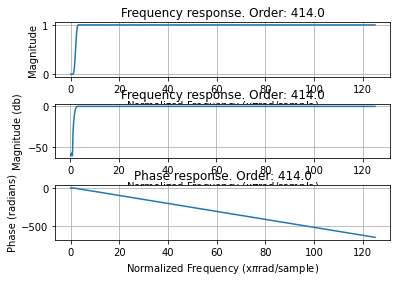

11.25
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [50.625] Hz



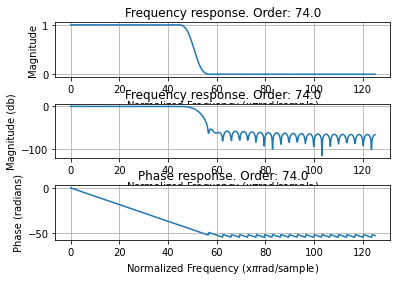

In [ ]:
electrodes = ['FCz','Oz','O1','PO7','O2','PO8','PO3','PO4'] # Electrodes used in the recording

fs = 250 # Sampling frecuency

low_fre = 3 # Low cut frecuency

high_fre = 45 # High cut frecuency

num_logmars = 7 # Number of logmars evaluated

# Filters design

order, highpass = filter_design(fs, locutoff = low_fre, hicutoff = 0, revfilt = 1)

mfreqz(highpass,1,order, fs/2)

order, lowpass = filter_design(fs, locutoff = 0, hicutoff = high_fre, revfilt = 0)

mfreqz(lowpass,1,order, fs/2)




In [ ]:
def scalogram(signal, sampling_frequency, frequency_band, path):

  sampling_period =  1/sampling_frequency
  Frequency_Band = frequency_band #Corresponde a la banda de frecuencia a analizar [4, 13]

  # Métodos de obtener las escalas para el Complex Morlet Wavelet  
  # Método 1:
  # Determinar las frecuencias respectivas para una escalas definidas
  scales = np.arange(1, 250)
  frequencies = pywt.scale2frequency('cmor1.0-1.0', scales)/sampling_period
  # Extraer las escalas correspondientes a la banda de frecuencia a analizar
  scales = scales[np.where(frequencies >= Frequency_Band[0]) and np.where(frequencies <= Frequency_Band[1])] 

  points = signal.shape[0]

  #%%
  # Obtener el tiempo correspondiente a una epoca de la señal (en segundos)
  time_epoch = sampling_period*points

  # Analizar una epoca de un montaje (con las escalas del método 1)
  # Obtener el vector de tiempo adecuado para una epoca de un montaje de la señal
  time = np.arange(0, time_epoch, sampling_period)
  # Para la primera epoca del segundo montaje calcular la transformada continua de Wavelet, usando Complex Morlet Wavelet

  [coef, freqs] = pywt.cwt(signal, scales, 'cmor1.0-1.0', sampling_period)
  # Calcular la potencia 
  power = (np.abs(coef)) ** 2
  # Graficar el escalograma obtenido del análisis tiempo frecuencia
  f, ax = plt.subplots(figsize=(15, 10))
  scalogram = ax.contourf(time,
                  freqs,
                  power,
                  10, # Especificar 20 divisiones en las escalas de color 
                  extend='both')
  ax.set_ylim(np.amin(freqs), np.amax(freqs))
  ax.set_ylabel('frequency [Hz]')
  ax.set_xlabel('Time [s]')
  cbar = plt.colorbar(scalogram)

  # CAUTION! this code Always overwrites the plots
  
  #plt.savefig(path + '_spectrum.png')
  #plt.show()
 

### **Función para la carga de la señal**

---

In [ ]:
def signal_upload(signal_path, subject, eye, electrodes):

  '''
  Function created to upload a signal from a csv file to the enviroment of 
  work, saving it in a pandas DataFrame and then in a numpy array. In this 
  function, to all the channels is substracted Fcz channel that works as 
  a reference. Then the raw signal is plotted.

  Input: signal_path --> str (path where the csv file is located with the data)

         subject --> str (code of identification of the subject)

         eye --> str (signal that will be uploaded ej. both_eyes, left or right)

         electrodes --> list (contains the names of the electrodes used in the recording)
         

  Output: vision_signal --> Numpy array (array with the uploaded signal)

          signals_marks --> Numpy array (array where the marks are located)
  '''

  vision_signal = pd.read_csv(signal_path, index_col=False, header = None, sep = ';')

  signal_marks = vision_signal.iloc[:,8].to_numpy()

  vision_signal = vision_signal.iloc[:,0:8]

  vision_signal = vision_signal.to_numpy()

  OpenBCI_factor = ((4500000)/24/(2**23-1)) #Factor reported in OpenBCI documentation

  vision_signal = vision_signal*OpenBCI_factor

  vision_signal = vision_signal - np.repeat(vision_signal[:,0,np.newaxis],8,1)

  vision_signal = vision_signal[:,1:]

  num_channels = vision_signal.shape[1]

  plt.figure(figsize=(12,5))

  for c in range(num_channels):

    plt.title(" Raw signal of " + subject +" "+ eye )

    plt.plot(vision_signal[:,c] + 1*c,label = electrodes[c+1])

    plt.grid()

    plt.legend(loc = 4)

  plt.show()

  return vision_signal, signal_marks

### **Función para realiza el filtrado de la señal y visualización**

---

In [ ]:
def signal_filtering(uploaded_signal, subject, eye, electrodes, highpass, lowpass):

  '''
  Function that filters the signal. First, linear tendences are eliminated. Then,
  using designed linear filters (highpass and lowpass) the function defines
  a range of frecuencies. Last, using a non-linear filter (wavelet) the signal
  is filtrated again and plots the result.

  Inputs: uploaded_signal --> Numpy array (signal to be filtered)

          subject --> str (code of identification of the subject)

          eye --> str (signal that will be uploaded ej. both_eyes, left or right)

          electrodes --> list (contains the names of the electrodes used in the recording)

          highpass --> Numpy array (highpass filter)

          lowpass --> Numpy array (lowpass filter)


  Output: filtered signal --> Numpy array (resulting signal of the filtering process)
  '''


  vision_signal = signal.detrend(uploaded_signal, axis=0, type='linear')

  num_channels = vision_signal.shape[1]

  filtered_signal = np.zeros((len(vision_signal), num_channels))

  for c in range(num_channels):

    LL_ind = int(np.floor(np.log2(vision_signal[:,c].shape[0])))

    coeff_ind = pywt.wavedec(vision_signal[:,c], 'db6', level=8)

    thr = thselect(coeff_ind)

    s = wnoisest(coeff_ind)

    coeff_t = wthresh(coeff_ind,thr,s)

    x_rec = pywt.waverec(coeff_t, 'db6')

    resta = vision_signal[:,c] - x_rec[:len(vision_signal)]

    senal_w_hp = signal.filtfilt(highpass, 1, resta)

    senal_filt = signal.filtfilt(lowpass, 1, senal_w_hp)

    filtered_signal[:,c] = senal_filt

  plt.figure(figsize=(12,5))

  for c in range(num_channels):

    plt.title(" Filtered signal of "+ subject + " " + eye)

    plt.plot(filtered_signal[:,c] + 100*c,label = electrodes[c+1])

    plt.legend(loc = 4)

    plt.grid()

  plt.show()

  return filtered_signal

### **Función para visualización del periodograma y ejecución del escalograma (visualización de periodograma y espectro)**

---

In [ ]:
def periodogram(signal_filtered, marks, num_logmars, sampling_frecuency, subject, eye, signal_path):

  '''
  Funtion to obtain the periodogram of each logmar for each signal using Welch
  technique, then, it is plotted and saved.

  Inputs: signal_filtered --> Numpy array (signal to be used to find the periodogram)

          marks --> Numpy array (array with the same length of the signal that
                    contains the marks)

          num_logmars --> int (talking about visual acuity, the number of logmar
                                that had been evaluated in the recording ej. 7)

          sampling_frecuency --> int (sampling frecuency of the EEG recorder)

          subject --> str (code of identification of the subject)

          eye --> str (signal that will be uploaded ej. both_eyes, left or right)

          signal_path --> str (path where the plots will be saved)

  '''
  path_save = signal_path[0:len(signal_path)-4]

  fs = sampling_frecuency

  SNR_counter = 0 # Counter for signals that have SNR > 1

  harmonics_SNRCounter = 0 # Counter for signals that have SNR > 1 in the first harmonic of the stimulation frequency

  SNR_subject = []

  if not os.path.exists(path_save):

    os.makedirs(path_save)

  index = np.where( marks != 0.0)

  mark = index[0].tolist()

  if mark:

    for i in range(len(mark)-1):

      f, Pxx = signal.welch( signal_filtered[mark[6]:mark[7],0], sampling_frecuency, nperseg = 2 * sampling_frecuency, noverlap = sampling_frecuency, nfft=None, return_onesided=True)

      if '5' in eye:

        stimulation_freq = 5

      if '6' in eye:

        stimulation_freq = 6
          
      prom = ( Pxx[(2*stimulation_freq)-1] + Pxx[(2*stimulation_freq+1)] )/2

      harmonic_prom = ( Pxx[(4*stimulation_freq)-1] + Pxx[(4*stimulation_freq+1)] )/2

      SNR = Pxx[(2*stimulation_freq)] / prom

      harmonic_SNR = Pxx[(4*stimulation_freq)] / harmonic_prom

      SNR_subject.append(SNR)

      if SNR > 1:

        SNR_counter += 1

        if harmonic_SNR > 1:

          harmonics_SNRCounter += 1

      plt.title('Signal_' + subject + '_' + acuity_signals + ' ' + 'logmar ' + str(i+1))

      plt.stem(f,Pxx)

      plt.xticks(range(20))

      plt.xlim([0,14])

      plt.grid()

      # CAUTION! this code Always overwrites the plots

      logmar_path = os.path.join(path_save,'logmar_' + str(i+1))

      plt.savefig(logmar_path  + '.png')

      scalogram(filtered_signal[i*1000:(i+1)*1000,0], fs, [0, 10], logmar_path)

    plt.show()

  else:

    SNR = np.nan

    SNR_subject.append(SNR)

  return SNR_counter, harmonics_SNRCounter, SNR_subject


  

### **Búsqueda de señales en el directorio**
---

In [ ]:
signals_WSNR = 0

signals_WHarmonic_SNR = 0

SNR_list = []

for group in os.listdir(path):

  for subject in os.listdir(os.path.join(path, group)):

      for acuity_signals in os.listdir(os.path.join(path, group, subject)):

        if os.path.isfile(os.path.join(path, group, subject, acuity_signals)):

          signal_path = os.path.join(path, group, subject, acuity_signals)

          signal_uploaded, marks = signal_upload(signal_path, subject, acuity_signals, electrodes)

          filtered_signal = signal_filtering(signal_uploaded, subject, acuity_signals, electrodes, highpass, lowpass)

          signals_WSNRa, signals_WHarmonic_SNRa, SNR_subjecta = periodogram(filtered_signal, marks, num_logmars, fs, subject, acuity_signals, signal_path)

          signals_WSNR = signals_WSNR + signals_WSNRa

          signals_WHarmonic_SNR = signals_WHarmonic_SNR + signals_WHarmonic_SNRa

          SNR_list +=  SNR_subjecta


print('señales con el pico en la frecuencia de interes: ', signals_WSNR,'señales con el pico en el harmonico: ', signals_WHarmonic_SNR)


P1_14-07-2021
1
P1_14-07-2021
2
P2_21-07-2021
3
P3_22-07-2021
4
P4_22-07-2021
5
P5_24-07-2021
6
P5_24-07-2021
7
P6_24-07-2021
8
P6_24-07-2021
9
P7_26-07-2021
10
señales con el pico en la frecuencia de interes:  9 señales con el pico en el harmonico:  9
promedio SNR: 1.2406775254318654
STD SNR: 0.19511681667502637
